# Playground with new indices

### 1. Import Python libraries and functions.

In [1]:
%matplotlib inline

# Base
import os
import numpy as np
import pandas as pd

# Spatial analysis
import rasterio as rio
import fiona as fio
from fiona.crs import from_epsg
from pyproj import Proj, transform

# Visualization
import matplotlib.pyplot as plt

# Additional scripts
from scripts.clip_area import clip_area
from scripts.read_landsat_images import read_landsat_images
from scripts.show_band import show_band

# Runetime Warnings Disabling
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

### 2. Prepare time series Data Frame with Landsat 8 scenes (class RasterTimeSeries).

In [2]:
class RasterTimeSeries:
    """Class prepares dataframe object with addresses to the folders with landsat bands. Dataframe index is a time when each scene was retrieved.
    It is initialized with the folder which contains all landsat bands.
    
    Class methods:
    prepare_directories(main_folder=None) - method prepares a list of folders with satellite images. Method performs search in the parent directory
    given by the user or if it is None then it is taken from the class itself."""
    
    def __init__(self, main_folder):
        self.main_folder = main_folder
        self.landsat_folders = None
        self.landsat_dataframe = None
    
    def prepare_directories(self, main_folder=None):
        """Function prepares list with Landsat images directories in the given folder.
        input 1: main_folder (string)
        If None then self.main_folder is used as the parent directory of the folders with satellite images.
        output: prepared_list - list with all folders with satellite images."""
        
        if main_folder:
            folder_name = os.listdir(main_folder)
        else:
            folder_name = self.main_folder
        raw_list = os.listdir(folder_name)
        prepared_list = []
        for folder in raw_list:
            if ((folder.startswith('LC')) and not (folder.endswith('.tar.gz'))):
                prepared_list.append(folder_name + '/' + folder + '/')
        self.landsat_folders = prepared_list
        return prepared_list
    
    @staticmethod
    def read_timestamp(folder):
        """Function reads date of acquisition of each Landsat 8 scene based on the folder with MTL file.
        input 1: folder - string with Landsat folder (MTL file must be placed in it).
        output: string with the scene acquisition time"""
    
        files = os.listdir(folder)
        for file in files:
            if file.startswith('LC') and file.endswith('MTL.txt'):
                address = folder + '/' + file
                with open(address, 'r') as f:
                    for line in f:
                        line = ''.join(line.split())
                        if line.startswith('DATE_ACQUIRED='):
                            line = line.replace('DATE_ACQUIRED=', '')
                            return line
    
    def prepare_dataframe(self):
        """Function prepares dataframe with index column as a date of acquisition and the main column DIR which points
        to the directories with Landsat 8 images. Function takes one argument: the list of folders with Landsat 8 datasets.
        output: pandas dataframe with indexes set to the dates of acquisition and column indices folders with Landsat images."""
        
        # DataFrame preparation
        time_series = pd.DataFrame(self.landsat_folders, columns=['DIR'])
        time_series.index = time_series['DIR'].apply(lambda x: str(pd.to_datetime(self.read_timestamp(x)).date()))
        time_series.index.name = 'DATE'
        time_series = time_series.sort_index()
        self.landsat_dataframe = time_series
        return time_series
    
    def __str__(self):
        if self.landsat_folders is None:
            return('Parent folder of all scenes: {}.\
            \nList of subfolders is not created.\
            \nDataframe with dates is not created.'.format(
            self.main_folder))
        elif self.landsat_dataframe is None:
            return('Parent folder of all scenes: {}\
            \nList of subfolders has {} directories.\
            \nDataframe with dates is not created.'.format(
            self.main_folder, len(self.landsat_folders)))
        else:
            return('Parent folder of all scenes: {}\
            \nList of subfolders has {} directories.\
            \nDataframe is created. List of all dates: {}.'.format(
            self.main_folder,
            len(self.landsat_folders),
            self.landsat_dataframe.index.values))

In [3]:
folder = 'data/rasters'
algal_blooms = RasterTimeSeries(folder)
print(algal_blooms)

Parent folder of all scenes: data/rasters.            
List of subfolders is not created.            
Dataframe with dates is not created.


In [4]:
algal_blooms.prepare_directories()
print(algal_blooms)

Parent folder of all scenes: data/rasters            
List of subfolders has 15 directories.            
Dataframe with dates is not created.


In [5]:
algal_blooms.prepare_dataframe()
print(algal_blooms)

Parent folder of all scenes: data/rasters            
List of subfolders has 15 directories.            
Dataframe is created. List of all dates: ['2013-04-15' '2013-05-01' '2013-05-17' '2013-06-18' '2013-08-05'
 '2013-09-06' '2014-07-07' '2015-04-21' '2015-08-11' '2017-04-10'
 '2017-05-12' '2017-05-28' '2018-04-13' '2018-05-31' '2018-08-03'].


### 3. Prepare class which reads, stores, shows and reprojects vector shapefiles.

In [6]:
# Helper function to prepare the data

def get_epsg_from_raster(raster_address):
    """Function reads raster data and gets its coordinate reference system.
    Then it is converted to the European Petroleum Survey Group (EPSG) reference number.
    Function was tested only with the Landsat rasters."""
    with rio.open(raster_address) as f:
        band_crs = f.crs
        destination_epsg = band_crs['init'][5:]
        destination_epsg = int(destination_epsg)
    return destination_epsg


# The main class for vector file handling

class VectorData:
    """Class reads, stores, shows and reprojects vector shapefiles.
    It is initialized with filename.
    
    Class methods:
    get_vector_data(parameters='all', write_params=True) - method reads vector data and parse its parameters such as geometry,
    properties, crs and schema into dictionaries. Method may store parameters inside the object if write_params is set
    to True. Method returns desired parameters.
    reproject_geometry(destination_epsg, update=False) - method changes projection of each point inside the Polygon into
    projection given as an epsg number. It may update object geometry if the update parameter is set to True. Method returns
    reprojected geometry dictionary.
    show_vector_data(geometry=None) - method shows polygon. If geometry is not given then method uses class geometry."""
    
    def __init__(self, filename):
        self.v_file = filename
        self.geometry = {}
        self.properties = None
        self.vec_crs = None
        self.vec_schema = None
        
    def get_vector_data(self, parameters='all', write_params=True):
        """
        Function reads vector and its parameters and return them and / or store them inside the objects instance.
        input 1: parameters (string)
        parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'
        'all': returns tuple with geometry, properties, crs and schema;
        'none': does not return anything;
        'geometry', 'properties', 'crs' or 'schema': returns chosen parameter.
        input 2: write_params (bool)
        write_params: True, False
        True: store all parameters in the object
        False: do not store anything in the object
        output: chosen parameters as a dict"""
        
        with fio.open(self.v_file, 'r') as masking_region:
            geometry = [feature["geometry"] for feature in masking_region]
            properties = [feature['properties'] for feature in masking_region]
            vec_crs = masking_region.crs
            vec_schema = masking_region.schema
        
        if write_params:
            print('--- Object geometry, properties, crs and schema updated ---')
            self.geometry = geometry
            self.properties = properties
            self.vec_crs = vec_crs
            self.vec_schema = vec_schema
        else:
            print('--- Object parameters not updated ---')
            
        output_dict = {'all': ({'geometry': geometry, 'properties': properties, 'crs': vec_crs, 'scheme': vec_schema}),
                      'none': 0,
                      'geometry': geometry,
                      'properties': properties,
                      'crs': vec_crs,
                      'schema': vec_schema}
        try:
            return output_dict[parameters]
        except KeyError:
            raise KeyError("Parameter not available. Available parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'")
      
    def reproject_geometry(self, destination_epsg, update=False):
        """
        Function reprojects vector geometry and updates it.
        input 1: destination_epsg (string or int)
        input 2: update (bool)
        True: update object's geometry
        False: do not update object's geometry
        output: reprojected geometry as a dict"""
        
        try:
            destination_crs = from_epsg(destination_epsg)
            proj_crs_in = Proj(self.vec_crs)
            coordinates_list = self.geometry[0]['coordinates'][0]
        except RuntimeError:
            raise ValueError('Given EPSG is wrong or it is not stored in fiona to run from_epsg method')
        except KeyError:
            raise ValueError('You must update your object parameters by get_vector_data method with write_params set to True.')
        proj_crs_out = Proj(init = destination_crs['init'])
        coordinates_array = np.asarray(coordinates_list)
        projected_g = []
        
        for g in coordinates_array:
            transformed = transform(proj_crs_in, proj_crs_out, g[0], g[1])
            points = (transformed[0], transformed[1],)
            projected_g.append(points)
        geometry_dict = {'coordinates': [projected_g], 'type': 'Polygon'}
        
        if update:
            self.geometry = [geometry_dict]
            self.vec_crs = destination_crs
            
        return [geometry_dict]
    
    def show_vector_data(self, geometry=None):
        """
        Function shows vector geometry.
        input 1: geometry (dict, geometry retrieved as a parameter from the vector data type).
        If geometry is not given then method takes it from the objects instance."""
        
        if geometry:
            g = geometry
        else:
            g = self.geometry
            
        try:
            coordinates_list = g[0]['coordinates'][0]
        except KeyError:
            raise ValueError(
                'Geometry is not defined. Please, update geometry with get_vector_data method or provide valid geometry object to the method.')
            
        coordinates_array = np.asarray(coordinates_list)
        plt.figure()
        plt.plot(coordinates_array[:, 0], coordinates_array[:, 1])
        plt.show()

### 4. Example 1: differences between projections.

--- Object geometry, properties, crs and schema updated ---


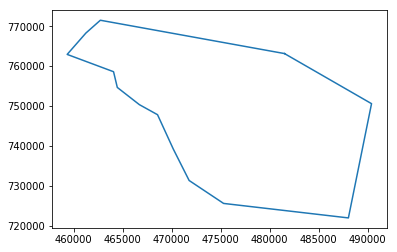

{'proj': 'tmerc', 'lat_0': 0, 'lon_0': 19, 'k': 0.9993, 'x_0': 500000, 'y_0': -5300000, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}


In [7]:
vector_file = 'data/vector/zatoka_gdanska.shp'
vector_data = VectorData(vector_file)
vd = vector_data.get_vector_data('geometry', True)
vector_data.show_vector_data(vd)
print(vector_data.vec_crs)

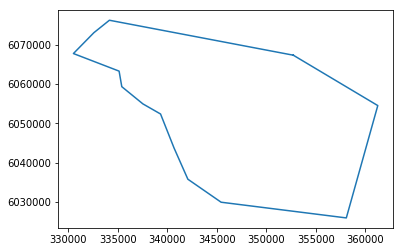

{'init': 'epsg:32634', 'no_defs': True}


In [8]:
df = algal_blooms.landsat_dataframe
landsat_images = read_landsat_images(df['DIR'][0])
epsg = get_epsg_from_raster(landsat_images[1])
vn = vector_data.reproject_geometry(epsg, True)
vector_data.show_vector_data()
print(vector_data.vec_crs)

### 5. Example 2: errors with clipping data with different projections.

In [9]:
# Read and prepare vector data

vector_file = 'data/vector/zatoka_gdanska.shp'
vector_data = VectorData(vector_file)
vector_data.get_vector_data('geometry', True)
print(vector_data.vec_crs)

--- Object geometry, properties, crs and schema updated ---
{'proj': 'tmerc', 'lat_0': 0, 'lon_0': 19, 'k': 0.9993, 'x_0': 500000, 'y_0': -5300000, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}


In [10]:
# Read raster file and check its crs

with rio.open(landsat_images[1]) as f:
    band_crs = f.crs

print(band_crs)

CRS({'init': 'epsg:32634'})


In [11]:
# Try to clip areas with different projections

clip_area(vector_data.geometry, landsat_images[1], 'data/failed_test.tif')

ValueError: Input shapes do not overlap raster.

### 6. Example 3: clip raster (valid one).

--- Object geometry, properties, crs and schema updated ---


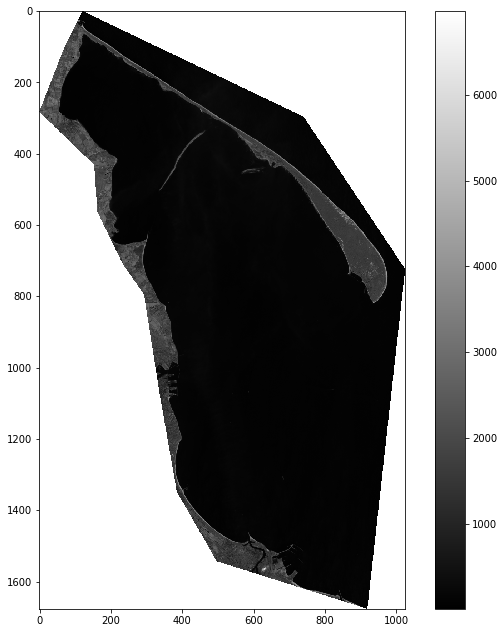

In [12]:
# Read and prepare vector data
vector_file = 'data/vector/zatoka_gdanska.shp'
vector_data = VectorData(vector_file)
vector_data.get_vector_data('geometry', True)

# Get projection from raster file
df = algal_blooms.landsat_dataframe
landsat_images = read_landsat_images(df['DIR'][0])
epsg = get_epsg_from_raster(landsat_images[1])

# Reproject vector geometry
vn = vector_data.reproject_geometry(epsg, False)

# Clip raster and show it!
clip_area(vn, landsat_images[5], 'data/correct_test.tif')

# Show raster
with rio.open('data/correct_test.tif') as correct_clip:
    area_of_interst = correct_clip.read(1)
show_band(area_of_interst)

### 7. Clip multiple rasters and update dataframe.

In [13]:
def clip_all(dataset, clipping_vector, bands=(2, 3, 4), folder_name='clipped/'):
    """Function performs clipping of all Landsat 8 bands given in the DIR column of the df parameter.
    input 1: dataset - dataframe with DIR column where each record points to the directory with a Landsat bands
    input 2: clipping_vector - vector geometry which is used as a area of interest
    input 3: bands=(2, 3, 4) - tuple of bands which should be clipped. Bands 2, 3, 4 are used for the BGR image creation.
    input 4: folder_name='clipped/' - directory where all clipped bands should be stored.
    
    output: [correct, damaged] - list of dicts with keys (dates) and values - correct images
    and damaged images. Damaged images were not process and they not exist in the destination folder."""
    
    data_range = len(dataset)
    damaged = {}
    correct = {}
    for i in range(0, data_range):
        date_str = dataset.index[i]
        images = read_landsat_images(dataset['DIR'][i])
        for band_number in bands:
            band_to_clip = images[band_number]
            filename = folder_name + 'LC_band' + str(band_number) + '_' + date_str + '.tif'
            try:
                clip_area(vn, band_to_clip, filename)
            except (rio.errors.WindowError, ValueError):
                print('\nPolygon does not cover raster area. Error occurs when projections are different or raster extent is translated and it does not overlap polygon extent.\n')
                try: 
                    damaged[date_str].append(filename)
                except KeyError:
                    damaged[date_str] = [filename]
                pass
            
            # Check file
            try: 
                damaged[date_str]
                print('File: {} not saved. Raster has not been clipped.'.format(
                filename))
            except KeyError:
                try:
                    with rio.open(filename) as tf:
                         pass
                except rio.RasterioIOError:
                    raise IOError('File was: {} not saved successfully'.format(
                    filename))
                else:
                    print('File: {} saved successfully'.format(
                    filename))
                    try: 
                        correct[date_str].append(filename)
                    except KeyError:
                        correct[date_str] = [filename]
    return [correct, damaged]

In [14]:
my_bands = (1, 2, 3, 4, 5)  # bands for EVI, Kab1 and Kab2 calculation
my_folder_name = 'data/clipped/'
prepared_files = clip_all(df, vn, my_bands, my_folder_name)

File: data/clipped/LC_band1_2013-04-15.tif saved successfully
File: data/clipped/LC_band2_2013-04-15.tif saved successfully
File: data/clipped/LC_band3_2013-04-15.tif saved successfully
File: data/clipped/LC_band4_2013-04-15.tif saved successfully
File: data/clipped/LC_band5_2013-04-15.tif saved successfully
File: data/clipped/LC_band1_2013-05-01.tif saved successfully
File: data/clipped/LC_band2_2013-05-01.tif saved successfully
File: data/clipped/LC_band3_2013-05-01.tif saved successfully
File: data/clipped/LC_band4_2013-05-01.tif saved successfully
File: data/clipped/LC_band5_2013-05-01.tif saved successfully
File: data/clipped/LC_band1_2013-05-17.tif saved successfully
File: data/clipped/LC_band2_2013-05-17.tif saved successfully
File: data/clipped/LC_band3_2013-05-17.tif saved successfully
File: data/clipped/LC_band4_2013-05-17.tif saved successfully
File: data/clipped/LC_band5_2013-05-17.tif saved successfully
File: data/clipped/LC_band1_2013-06-18.tif saved successfully
File: da

In [15]:
def rasters_to_dataframe(raster_list, dataframe):
    """Function reads list of dictionaries with correct and damaged files. Keys in the dictionary are related to the dates
    of an image acquisition. The first list presents correct data. Second list represents damaged values.
    input 1: raster_list - list of dictionaries with correct and damaged files.
    input 2: dataframe - dataframe with dates which should be removed (if band is in the damaged list) or 
    updated with new columns with addresses to the correct raster files.
    
    output: clean_dataset - pandas dataframe with additional columns with addresses of the raster files. These files
    are intended to process them later."""
    
    damaged_list = list(raster_list[1].keys())
    clean_dataset = dataframe.drop(labels=damaged_list)
    correct_df = pd.DataFrame.from_dict(raster_list[0], orient='index')
    clean_dataset = clean_dataset.join(correct_df)
    return clean_dataset

In [16]:
clean_df = rasters_to_dataframe(prepared_files, df)
clean_df.head()

,DIR,0,1,2,3,4
DATE,,,,,,
2013-04-15,data/rasters/LC081900222013041501T1-SC20180614...,data/clipped/LC_band1_2013-04-15.tif,data/clipped/LC_band2_2013-04-15.tif,data/clipped/LC_band3_2013-04-15.tif,data/clipped/LC_band4_2013-04-15.tif,data/clipped/LC_band5_2013-04-15.tif
2013-05-01,data/rasters/LC081900222013050101T1-SC20180614...,data/clipped/LC_band1_2013-05-01.tif,data/clipped/LC_band2_2013-05-01.tif,data/clipped/LC_band3_2013-05-01.tif,data/clipped/LC_band4_2013-05-01.tif,data/clipped/LC_band5_2013-05-01.tif
2013-05-17,data/rasters/LC081900222013051701T1-SC20180614...,data/clipped/LC_band1_2013-05-17.tif,data/clipped/LC_band2_2013-05-17.tif,data/clipped/LC_band3_2013-05-17.tif,data/clipped/LC_band4_2013-05-17.tif,data/clipped/LC_band5_2013-05-17.tif
2013-06-18,data/rasters/LC081900222013061801T1-SC20180614...,data/clipped/LC_band1_2013-06-18.tif,data/clipped/LC_band2_2013-06-18.tif,data/clipped/LC_band3_2013-06-18.tif,data/clipped/LC_band4_2013-06-18.tif,data/clipped/LC_band5_2013-06-18.tif
2013-08-05,data/rasters/LC081900222013080501T1-SC20180614...,data/clipped/LC_band1_2013-08-05.tif,data/clipped/LC_band2_2013-08-05.tif,data/clipped/LC_band3_2013-08-05.tif,data/clipped/LC_band4_2013-08-05.tif,data/clipped/LC_band5_2013-08-05.tif


### 8. Calculate Kab1, Kab2 and EVI

In [17]:
# Calculate EVI

def select_bands(numbers, all_bands):
    selected_bands = []
    for number in numbers:
        band_desc = 'LC_band' + str(number) + '_'
        for band_name in all_bands:
            if type(band_name) is not str:
                pass
            else:
                if band_desc in band_name:
                    selected_bands.append(band_name)
    selected_bands.sort()
    return selected_bands

def calculate_indicator(bands, indicator):
    """Function calculates chosen indicator from given data and returns it as 
    a map (numpy array)"""
    if indicator == 'evi':
        bands = select_bands([2, 4, 5], bands)
        
        with rio.open(bands[2]) as a:
            nir_band = (a.read()[0]/10000).astype(np.float)
        with rio.open(bands[1]) as b:
            r_band = (b.read()[0]/10000).astype(np.float)
        with rio.open(bands[0]) as c:
            b_band = (c.read()[0]/10000).astype(np.float)
        
        numerator = nir_band - r_band
        g = 2.5
        c1 = 6
        c2 = 7.5
        l = 1
        denominator = nir_band + c1 * r_band - c2 * b_band + l
        evi = g * (numerator / denominator)
        evi[evi > 1] = 1
        return evi
        
    elif indicator == 'kab1':
        # 1.67 - 3.94 * ln(B2) + 3.78 * ln(B3)
        bands = select_bands([2, 3], bands)
        
        with rio.open(bands[0]) as a:
            blue_band = (a.read()[0]).astype(np.float)
            blue_band[blue_band < 0] = 0
        with rio.open(bands[1]) as b:
            green_band = (b.read()[0]).astype(np.float)
            green_band[green_band < 0] = 0
        
        log_blue = np.log1p(blue_band)
        log_green = np.log1p(green_band)
        kab1 = 1.67 - 3.94 * log_blue + 3.78 * log_green
        return kab1
    
    elif indicator == 'kab2':
        # 6.92274 - 5.7581 * (ln(B1)/ln(B3))
        bands = select_bands([1, 3], bands)
        
        with rio.open(bands[0]) as a:
            ultra_blue_band = (a.read()[0]).astype(np.float)
            ultra_blue_band[ultra_blue_band < 0] = 0
        with rio.open(bands[1]) as b:
            green_band = (b.read()[0]).astype(np.float)
            green_band[green_band < 0] = 0
        
        log_blue = np.log1p(ultra_blue_band)
        log_green = np.log1p(green_band)
        kab2 = 6.92274 - 5.7581 * (log_blue / log_green)
        return kab2
    
    else:
        info = 'Your indicator {} is not implemented. Available indices: evi, Kab1, Kab2'.format(
        indicator)
        raise ValueError(info)

In [18]:
evi_clean_df = clean_df.apply(lambda x: np.nanmean(calculate_indicator(x, 'evi')), axis=1)
kab1_clean_df = clean_df.apply(lambda x: np.nanmean(calculate_indicator(x, 'kab1')), axis=1)
kab2_clean_df = clean_df.apply(lambda x: np.nanmean(calculate_indicator(x, 'kab2')), axis=1)

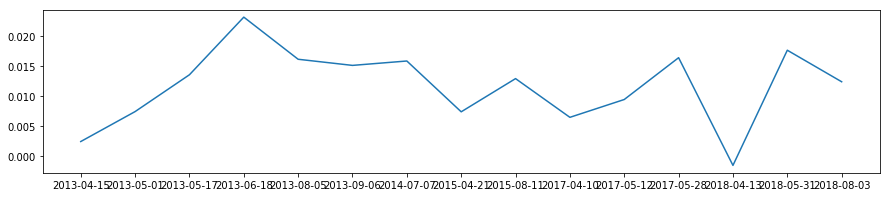

In [19]:
plt.figure(figsize=(15, 3))
plt.plot(evi_clean_df.index, evi_clean_df)
plt.show()

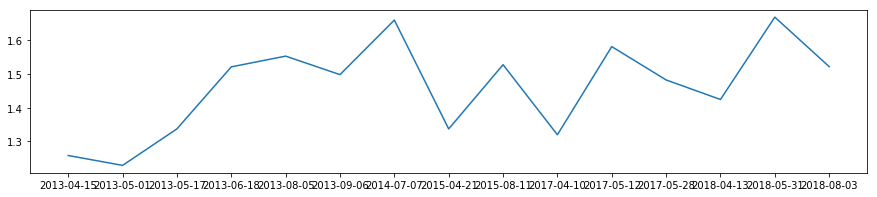

In [20]:
plt.figure(figsize=(15, 3))
plt.plot(kab1_clean_df.index, kab1_clean_df)
plt.show()

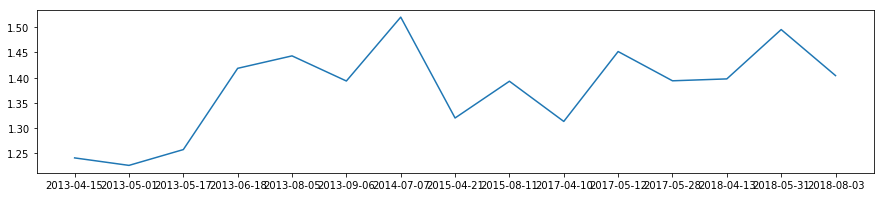

In [21]:
plt.figure(figsize=(15, 3))
plt.plot(kab2_clean_df.index, kab2_clean_df)
plt.show()

### 9. Why will it be very hard to obtain a valid results? - an example

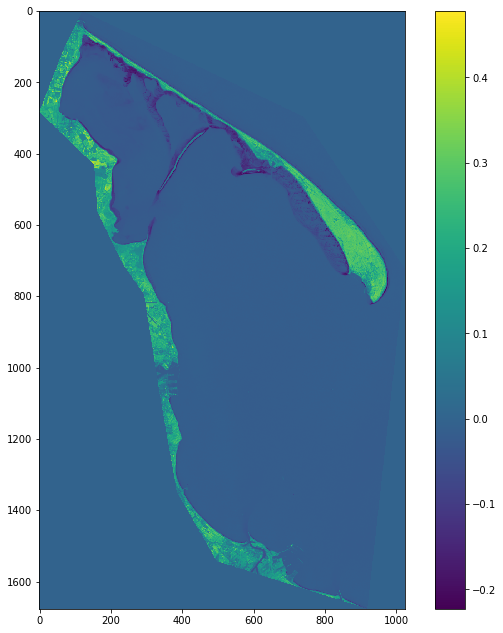

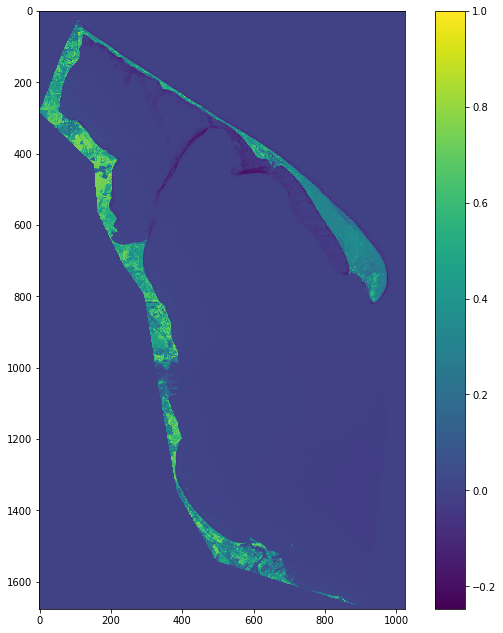

2013-04-15:  0.002377520652484955
2013-06-18:  0.023207237563491728


In [22]:
before = calculate_indicator(clean_df[clean_df.index == '2013-04-15'].values[0], 'evi')
show_band(before, color_map='viridis', remove_negative=False)

after = calculate_indicator(clean_df[clean_df.index == '2013-06-18'].values[0], 'evi')
show_band(after, color_map='viridis', remove_negative=False)
print('2013-04-15: ', np.nanmean(before))
print('2013-06-18: ', np.nanmean(after))

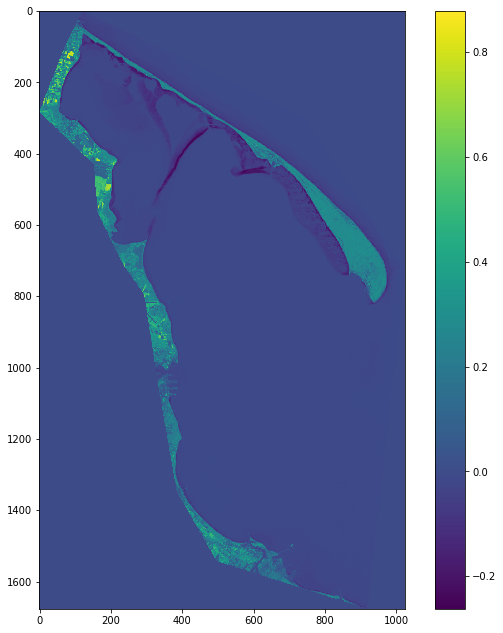

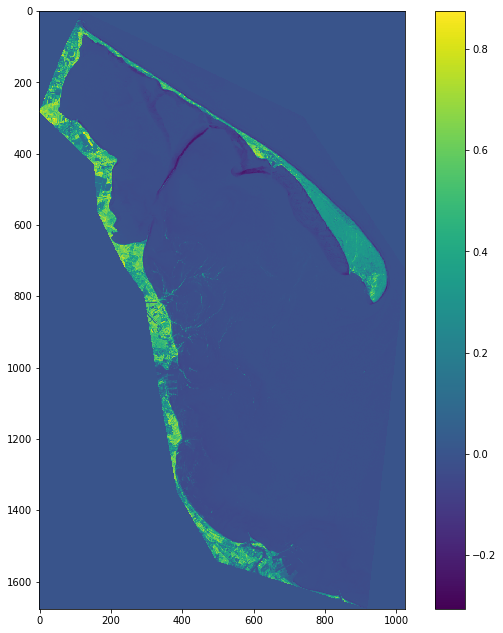

2015-04-21:  0.007355270029582324
2015-08-11:  0.012913711767003986


In [23]:
before = calculate_indicator(clean_df[clean_df.index == '2015-04-21'].values[0], 'evi')
show_band(before, color_map='viridis', remove_negative=False)
after = calculate_indicator(clean_df[clean_df.index == '2015-08-11'].values[0], 'evi')
show_band(after, color_map='viridis', remove_negative=False)
print('2015-04-21: ', np.nanmean(before))
print('2015-08-11: ', np.nanmean(after))

### 10. Calculate indices with corrected data.

In [24]:
# Read and prepare vector data
vector_file = 'data/vector/zatoka_v2.shp'
vector_data = VectorData(vector_file)
vector_data.get_vector_data('geometry', True)

# Get projection from raster file
df = algal_blooms.landsat_dataframe
landsat_images = read_landsat_images(df['DIR'][0])
epsg = get_epsg_from_raster(landsat_images[1])

# Reproject vector geometry
vn = vector_data.reproject_geometry(epsg, False)

# Prepare area of interest
my_bands = (1, 2, 3, 4, 5)  # bands for calculations
my_folder_name = 'data/clipped/'
prepared_files = clip_all(df, vn, my_bands, my_folder_name)

# Prepare dataframe and calculate indices
clean_df = rasters_to_dataframe(prepared_files, df)
evi_clean_df = clean_df.apply(lambda x: np.nanmean(calculate_indicator(x, 'evi')), axis=1)
kab1_clean_df = clean_df.apply(lambda x: np.nanmean(calculate_indicator(x, 'kab1')), axis=1)
kab2_clean_df = clean_df.apply(lambda x: np.nanmean(calculate_indicator(x, 'kab2')), axis=1)

--- Object geometry, properties, crs and schema updated ---
File: data/clipped/LC_band1_2013-04-15.tif saved successfully
File: data/clipped/LC_band2_2013-04-15.tif saved successfully
File: data/clipped/LC_band3_2013-04-15.tif saved successfully
File: data/clipped/LC_band4_2013-04-15.tif saved successfully
File: data/clipped/LC_band5_2013-04-15.tif saved successfully
File: data/clipped/LC_band1_2013-05-01.tif saved successfully
File: data/clipped/LC_band2_2013-05-01.tif saved successfully
File: data/clipped/LC_band3_2013-05-01.tif saved successfully
File: data/clipped/LC_band4_2013-05-01.tif saved successfully
File: data/clipped/LC_band5_2013-05-01.tif saved successfully
File: data/clipped/LC_band1_2013-05-17.tif saved successfully
File: data/clipped/LC_band2_2013-05-17.tif saved successfully
File: data/clipped/LC_band3_2013-05-17.tif saved successfully
File: data/clipped/LC_band4_2013-05-17.tif saved successfully
File: data/clipped/LC_band5_2013-05-17.tif saved successfully
File: data

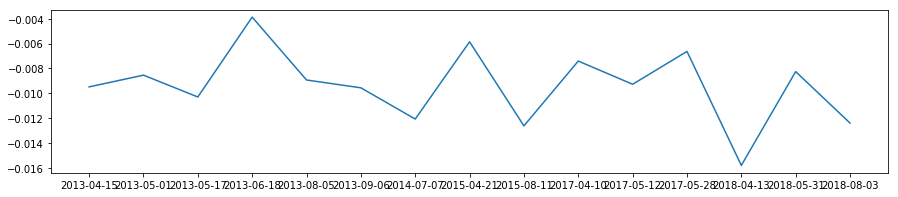

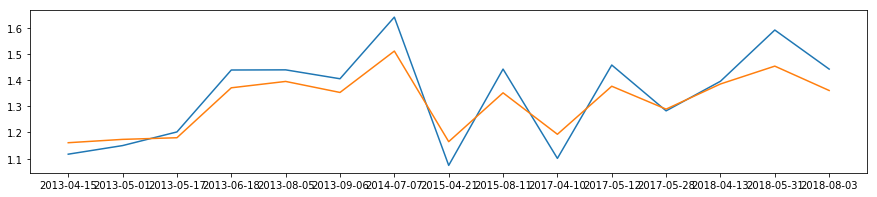

In [25]:
# Show indices over time
plt.figure(figsize=(15, 3))
plt.plot(evi_clean_df.index, evi_clean_df)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(kab1_clean_df.index, kab1_clean_df)
plt.plot(kab2_clean_df.index, kab2_clean_df)
plt.show()

### 11. Clouds and remote sensing.

In [26]:
class PixelQA:
    """Class removes clouds and cloud shadows from images based on the quality band given with Landsat's scene.
    Class is initialized with the folder with all Landsat scenes and the QA band.
    
    Class methods:
    prepare values(clear_key='all') - method prepares values to remove with accordance to the Landsat documentation:
    https://landsat.usgs.gov/landsat-surface-reflectance-quality-assessment.
    clear_pixels(band, qa_input = None, clear_by='all', nofill_value=0.0) - method clears pixels of a given band.
    Method takes band for cleaning (band) multiply it with (qa_input) where all values to remove are zeros and
    other values are ones. Removed pixels are filled by nofill_value."""
    
    
    def __init__(self, data_folder):
        
        # prepare qa file address
        file_list = os.listdir(data_folder)
        for f in file_list:
            if (f.startswith('LC') and f.endswith('pixel_qa.tif')):
                self.bqa_file = data_folder + f
        
        # prepare qa band
        with rio.open(self.bqa_file) as f:
            self.qa_band = f.read(1)
            
        # Dictionary with cloud pixel values for pixel_qa band 
        # (https://landsat.usgs.gov/landsat-surface-reflectance-quality-assessment)
        self.clouds = {'Cloud Shadow': [328, 392, 840, 904, 1350],
                      'Cloud': [352, 368, 416, 432, 480, 864, 880, 928, 944, 992],
                      'Cloud confidence': {'Low': [322, 324, 328, 336, 352, 368, 834, 836, 840, 848, 864, 880],
                                           'Medium': [386, 388, 392, 400, 416, 432, 900, 904, 928, 944],
                                           'High': [480, 992]},
                      'Cirrus confidence': {'Low': [322, 324, 328, 336, 352, 368, 386, 388, 392, 400, 416, 432, 480],
                                           'High': [834, 836, 840, 848, 864, 880, 898, 900, 904, 912, 928, 944, 992]}}
        
    def prepare_values(self, clear_key):
        """
        Function prepares values to remove (cloud pixels) based on the input.
        input 1: clear_key (string)
        parameters:
        'all' - returns values for Clouds and Cloud Shadows,
        'Cloud Shadow' - returns values for Cloud Shadows,
        'Cloud' - returns values for Clouds,
        'Cloud low' - returns pixel values which could be a cloud with low, medium and high probability,
        'Cloud medium' - returns pixel values which could be a cloud with medium and high probability,
        'Cloud high' - returns pixel values which could be a cloud with high probability,
        'Cirrus low' - returns pixel values which could be a cirrus with low and high probability,
        'Cirrus high' - returns pixel values which could be a cirrus with high probability.
        output: python list with pixel values to remove from the scene"""
        
        values = {'all': [self.clouds['Cloud Shadow'], self.clouds['Cloud']],
                 'Cloud Shadow': [self.clouds['Cloud Shadow']],
                 'Cloud': [self.clouds['Cloud']],
                 'Cloud low': [self.clouds['Cloud confidence']['Low'],
                               self.clouds['Cloud confidence']['Medium'],
                               self.clouds['Cloud confidence']['High']],
                 'Cloud medium': [self.clouds['Cloud confidence']['Medium'],
                                  self.clouds['Cloud confidence']['High']],
                 'Cloud high': [self.clouds['Cloud confidence']['High']],
                 'Cirrus low': [self.clouds['Cirrus confidence']['Low'],
                                self.clouds['Cirrus confidence']['High']],
                 'Cirrus high': [self.clouds['Cirrus confidence']['High']]}
        values_to_remove = values[clear_key]
        
        if len(values_to_remove) > 1:
            vals = []
            for values_list in values_to_remove:
                vals = vals + values_list
        else:
            vals = values_to_remove[0]
        return vals
    
    def clear_pixels(self, band, qa_input = None, clear_by='all', nofill_value=0.0):
        """
        Function removes cloud pixels from the chosen scene based on the scene quality band.
        input 1: band (numpy array) - band for the cloud removal.
        input 2: qa_input - if None then self.qa_band is used as the mask for cloud pixels. Else mask should be
        given as a numpy array.
        input 3: clear_all - parameter to obtain values of cloud pixels:
        'all' - returns values for Clouds and Cloud Shadows,
        'Cloud Shadow' - returns values for Cloud Shadows,
        'Cloud' - returns values for Clouds,
        'Cloud low' - returns pixel values which could be a cloud with low, medium and high probability,
        'Cloud medium' - returns pixel values which could be a cloud with medium and high probability,
        'Cloud high' - returns pixel values which could be a cloud with high probability,
        'Cirrus low' - returns pixel values which could be a cirrus with low and high probability,
        'Cirrus high' - returns pixel values which could be a cirrus with high probability.
        input 4: nofill_value - value which replaces cloud pixels.
        output: numpy array (scene) without cloud pixels."""
        
        values_to_remove = self.prepare_values(clear_by)
        if qa_input is None:
            qa_channel = self.qa_band
        else:
            qa_channel = qa_input
        for val in values_to_remove:
            qa_channel[qa_channel==val] = nofill_value
        qa_channel[qa_channel > 0] = 1
        output_band = band * qa_channel
        return output_band

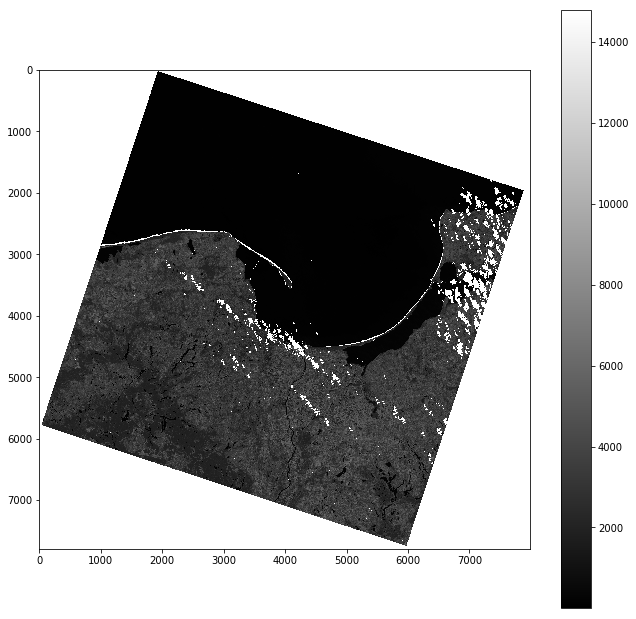

In [27]:
# Problems with clouds

qa_test = PixelQA('data/rasters/LC081900222013051701T1-SC20180614120419/')
with rio.open(
    'data/rasters/LC081900222013051701T1-SC20180614120419/LC08_L1TP_190022_20130517_20180301_01_T1_sr_band5.tif'
) as band:
    numpy_band = band.read(1)
    
cloud_show = qa_test.clear_pixels(numpy_band)
show_band(cloud_show)

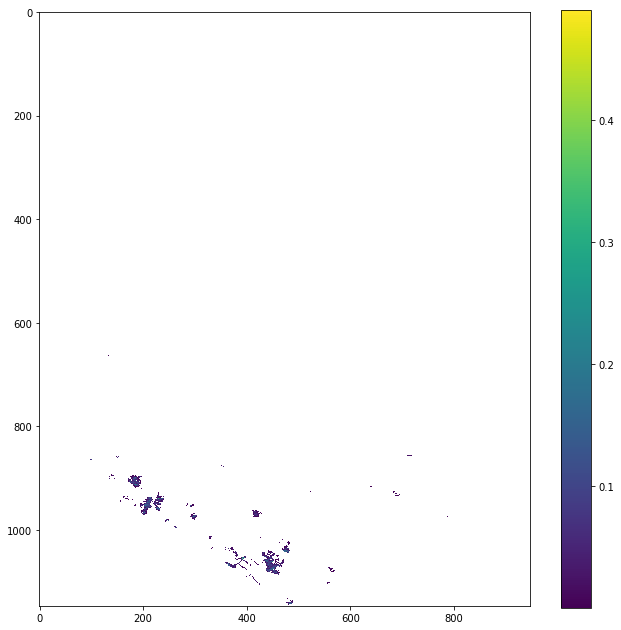

0.04982445501451065


In [28]:
# Quick test of clouds

clouds = calculate_indicator(clean_df[clean_df.index == '2013-05-17'].values[0], 'evi')
show_band(clouds, color_map='viridis', remove_negative=True)
print(np.nanmean(clouds[clouds > 0]))

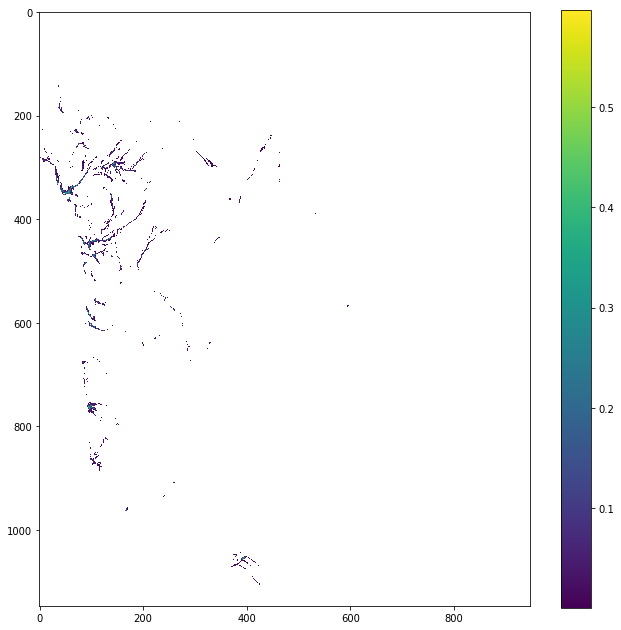

0.05321931650779935


In [29]:
algae = calculate_indicator(clean_df[clean_df.index == '2015-08-11'].values[0], 'evi')
show_band(algae, color_map='viridis', remove_negative=True)
print(np.nanmean(algae[algae > 0]))

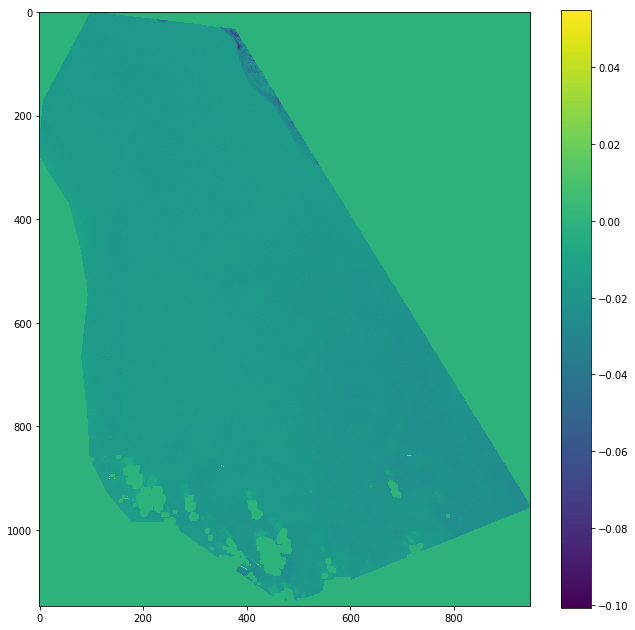

-0.010273081018352054


In [30]:
# Initialize qa band
qa_address = clean_df['DIR'].loc['2013-05-17']
qa_band = PixelQA(qa_address)

# Clip qa band
clip_area(vn, qa_band.bqa_file, 'data/LC_clipped_qa_pixel_qa.tif')
qa_band = PixelQA('data/')

# Remove clouds
clear_clouds = qa_band.clear_pixels(clouds)

# Show image without clouds
show_band(clear_clouds, color_map='viridis', remove_negative=False)
print(np.nanmean(clear_clouds))

### 12. Full pipeline to prepare rasters without clouds

In [31]:
# Change in the clip_all function to clip also qa bands
def clip_all(dataset, clipping_vector, bands=(2, 3, 4), qa_band=True, folder_name='clipped/'):
    """Function performs clipping of all Landsat 8 bands given in the DIR column of the df parameter.
    input 1: dataset - dataframe with DIR column where each record points to the directory with a Landsat bands
    input 2: clipping_vector - vector geometry which is used as a area of interest
    input 3: bands=(2, 3, 4) - tuple of bands which should be clipped. Bands 2, 3, 4 are used for the BGR image creation.
    input 4: folder_name='clipped/' - directory where all clipped bands should be stored.
    
    output: [correct, damaged] - list of dicts with keys (dates) and values - correct images
    and damaged images. Damaged images were not process and they not exist in the destination folder."""
    
    data_range = len(dataset)
    damaged = {}
    correct = {}
    for i in range(0, data_range):
        date_str = dataset.index[i]
        images = read_landsat_images(dataset['DIR'][i])
        
        # Cut bands
        for band_number in bands:
            band_to_clip = images[band_number]
            filename = folder_name + 'LC_band' + str(band_number) + '_' + date_str + '.tif'
            try:
                clip_area(vn, band_to_clip, filename)
            except (rio.errors.WindowError, ValueError):
                print('\nPolygon does not cover raster area. Error occurs when projections are different or raster extent is translated and it does not overlap polygon extent.\n')
                try: 
                    damaged[date_str].append(filename)
                except KeyError:
                    damaged[date_str] = [filename]
                pass
            
            # Check file
            try: 
                damaged[date_str]
                print('File: {} not saved. Raster has not been clipped.'.format(
                filename))
            except KeyError:
                try:
                    with rio.open(filename) as tf:
                         pass
                except rio.RasterioIOError:
                    raise IOError('File was: {} not saved successfully'.format(
                    filename))
                else:
                    print('File: {} saved successfully'.format(
                    filename))
                    try: 
                        correct[date_str].append(filename)
                    except KeyError:
                        correct[date_str] = [filename]
        
        # qa_band
        if qa_band:
            file_list = os.listdir(dataset['DIR'][i])
            for f in file_list:
                if (f.startswith('LC') and f.endswith('pixel_qa.tif')):
                    filename = folder_name + 'LC_band_' + date_str + '_pixel_qa.tif'
                    f = dataset['DIR'][i] + f
                    try:
                        clip_area(vn, f, filename)
                    except (rio.errors.WindowError, ValueError):
                        print('\nPolygon does not cover raster area. Error occurs when projections are different or raster extent is translated and it does not overlap polygon extent.\n')
                        try: 
                            damaged[date_str].append(filename)
                        except KeyError:
                            damaged[date_str] = [filename]
                        pass
            
                    # Check file
                    try: 
                        damaged[date_str]
                        print('File: {} not saved. Raster has not been clipped.'.format(filename))
                    except KeyError:
                        try:
                            with rio.open(filename) as tf:
                                 pass
                        except rio.RasterioIOError:
                            raise IOError('File was: {} not saved successfully'.format(filename))
                        else:
                            print('QA file: {} saved successfully'.format(filename))
                            try: 
                                correct[date_str].append(filename)
                            except KeyError:
                                correct[date_str] = [filename]
            
    return [correct, damaged]


# Read and prepare vector data
vector_file = 'data/vector/zatoka_v2.shp'
vector_data = VectorData(vector_file)
vector_data.get_vector_data('geometry', True)

# Get projection from raster file
df = algal_blooms.landsat_dataframe
landsat_images = read_landsat_images(df['DIR'][0])
epsg = get_epsg_from_raster(landsat_images[1])

# Reproject vector geometry
vn = vector_data.reproject_geometry(epsg, False)

--- Object geometry, properties, crs and schema updated ---


In [32]:
# Prepare area of interest
my_bands = (1, 2, 3, 4, 5)  # bands for indices calculation
my_folder_name = 'data/clipped/'
prepared_files = clip_all(df, vn, my_bands, True, my_folder_name)

# Prepare dataframe and calculate EVI
clean_df = rasters_to_dataframe(prepared_files, df)

File: data/clipped/LC_band1_2013-04-15.tif saved successfully
File: data/clipped/LC_band2_2013-04-15.tif saved successfully
File: data/clipped/LC_band3_2013-04-15.tif saved successfully
File: data/clipped/LC_band4_2013-04-15.tif saved successfully
File: data/clipped/LC_band5_2013-04-15.tif saved successfully
QA file: data/clipped/LC_band_2013-04-15_pixel_qa.tif saved successfully
File: data/clipped/LC_band1_2013-05-01.tif saved successfully
File: data/clipped/LC_band2_2013-05-01.tif saved successfully
File: data/clipped/LC_band3_2013-05-01.tif saved successfully
File: data/clipped/LC_band4_2013-05-01.tif saved successfully
File: data/clipped/LC_band5_2013-05-01.tif saved successfully
QA file: data/clipped/LC_band_2013-05-01_pixel_qa.tif saved successfully
File: data/clipped/LC_band1_2013-05-17.tif saved successfully
File: data/clipped/LC_band2_2013-05-17.tif saved successfully
File: data/clipped/LC_band3_2013-05-17.tif saved successfully
File: data/clipped/LC_band4_2013-05-17.tif saved

In [33]:
clean_df.head()

,DIR,0,1,2,3,4,5
DATE,,,,,,,
2013-04-15,data/rasters/LC081900222013041501T1-SC20180614...,data/clipped/LC_band1_2013-04-15.tif,data/clipped/LC_band2_2013-04-15.tif,data/clipped/LC_band3_2013-04-15.tif,data/clipped/LC_band4_2013-04-15.tif,data/clipped/LC_band5_2013-04-15.tif,data/clipped/LC_band_2013-04-15_pixel_qa.tif
2013-05-01,data/rasters/LC081900222013050101T1-SC20180614...,data/clipped/LC_band1_2013-05-01.tif,data/clipped/LC_band2_2013-05-01.tif,data/clipped/LC_band3_2013-05-01.tif,data/clipped/LC_band4_2013-05-01.tif,data/clipped/LC_band5_2013-05-01.tif,data/clipped/LC_band_2013-05-01_pixel_qa.tif
2013-05-17,data/rasters/LC081900222013051701T1-SC20180614...,data/clipped/LC_band1_2013-05-17.tif,data/clipped/LC_band2_2013-05-17.tif,data/clipped/LC_band3_2013-05-17.tif,data/clipped/LC_band4_2013-05-17.tif,data/clipped/LC_band5_2013-05-17.tif,data/clipped/LC_band_2013-05-17_pixel_qa.tif
2013-06-18,data/rasters/LC081900222013061801T1-SC20180614...,data/clipped/LC_band1_2013-06-18.tif,data/clipped/LC_band2_2013-06-18.tif,data/clipped/LC_band3_2013-06-18.tif,data/clipped/LC_band4_2013-06-18.tif,data/clipped/LC_band5_2013-06-18.tif,data/clipped/LC_band_2013-06-18_pixel_qa.tif
2013-08-05,data/rasters/LC081900222013080501T1-SC20180614...,data/clipped/LC_band1_2013-08-05.tif,data/clipped/LC_band2_2013-08-05.tif,data/clipped/LC_band3_2013-08-05.tif,data/clipped/LC_band4_2013-08-05.tif,data/clipped/LC_band5_2013-08-05.tif,data/clipped/LC_band_2013-08-05_pixel_qa.tif


In [34]:
class PixelQA:
    """Class removes clouds and cloud shadows from images based on the quality band given with Landsat's scene.
    Class is initialized with the folder with all Landsat scenes and the QA band.
    
    Class methods:
    prepare values(clear_key='all') - method prepares values to remove with accordance to the Landsat documentation:
    https://landsat.usgs.gov/landsat-surface-reflectance-quality-assessment.
    clear_pixels(band, qa_input = None, clear_by='all', nofill_value=0.0) - method clears pixels of a given band.
    Method takes band for cleaning (band) multiply it with (qa_input) where all values to remove are zeros and
    other values are ones. Removed pixels are filled by nofill_value.
    IMPORTANT:
    Script works only with the Landsat 8 Level-2 data products. To process Level 1 products you should use different
    values for cloud and cloud confidence estimation."""
    
    
    def __init__(self, qa_file=None, data_folder=None):
        
        # prepare qa file address
        if qa_file is None:
            file_list = os.listdir(data_folder)
            for f in file_list:
                if (f.startswith('LC') and f.endswith('pixel_qa.tif')):
                    self.bqa_file = data_folder + f
        else:
            self.bqa_file = qa_file
        
        # prepare qa band
        with rio.open(self.bqa_file) as f:
            self.qa_band = f.read(1)
            
        # Dictionary with cloud pixel values for pixel_qa band 
        # (https://landsat.usgs.gov/landsat-surface-reflectance-quality-assessment)
        self.clouds = {'Cloud Shadow': [328, 392, 840, 904, 1350],
                      'Cloud': [352, 368, 416, 432, 480, 864, 880, 928, 944, 992],
                      'Cloud confidence': {'Low': [322, 324, 328, 336, 352, 368, 834, 836, 840, 848, 864, 880],
                                           'Medium': [386, 388, 392, 400, 416, 432, 900, 904, 928, 944],
                                           'High': [480, 992]},
                      'Cirrus confidence': {'Low': [322, 324, 328, 336, 352, 368, 386, 388, 392, 400, 416, 432, 480],
                                           'High': [834, 836, 840, 848, 864, 880, 898, 900, 904, 912, 928, 944, 992]}}
        
    def prepare_values(self, clear_key):
        """
        Function prepares values to remove (cloud pixels) based on the input.
        input 1: clear_key (string)
        parameters:
        'all' - returns values for Clouds and Cloud Shadows,
        'Cloud Shadow' - returns values for Cloud Shadows,
        'Cloud' - returns values for Clouds,
        'Cloud low' - returns pixel values which could be a cloud with low, medium and high probability,
        'Cloud medium' - returns pixel values which could be a cloud with medium and high probability,
        'Cloud high' - returns pixel values which could be a cloud with high probability,
        'Cirrus low' - returns pixel values which could be a cirrus with low and high probability,
        'Cirrus high' - returns pixel values which could be a cirrus with high probability.
        output: python list with pixel values to remove from the scene"""
        
        values = {'all': [self.clouds['Cloud Shadow'], self.clouds['Cloud']],
                 'Cloud Shadow': [self.clouds['Cloud Shadow']],
                 'Cloud': [self.clouds['Cloud']],
                 'Cloud low': [self.clouds['Cloud confidence']['Low'],
                               self.clouds['Cloud confidence']['Medium'],
                               self.clouds['Cloud confidence']['High']],
                 'Cloud medium': [self.clouds['Cloud confidence']['Medium'],
                                  self.clouds['Cloud confidence']['High']],
                 'Cloud high': [self.clouds['Cloud confidence']['High']],
                 'Cirrus low': [self.clouds['Cirrus confidence']['Low'],
                                self.clouds['Cirrus confidence']['High']],
                 'Cirrus high': [self.clouds['Cirrus confidence']['High']]}
        values_to_remove = values[clear_key]
        
        if len(values_to_remove) > 1:
            vals = []
            for values_list in values_to_remove:
                vals = vals + values_list
        else:
            vals = values_to_remove[0]
        return vals
    
    def clear_pixels(self, band, qa_input = None, clear_by='all', nofill_value=0.0):
        """
        Function removes cloud pixels from the chosen scene based on the scene quality band.
        input 1: band (numpy array) - band for the cloud removal.
        input 2: qa_input - if None then self.qa_band is used as the mask for cloud pixels. Else mask should be
        given as a numpy array.
        input 3: clear_all - parameter to obtain values of cloud pixels:
        'all' - returns values for Clouds and Cloud Shadows,
        'Cloud Shadow' - returns values for Cloud Shadows,
        'Cloud' - returns values for Clouds,
        'Cloud low' - returns pixel values which could be a cloud with low, medium and high probability,
        'Cloud medium' - returns pixel values which could be a cloud with medium and high probability,
        'Cloud high' - returns pixel values which could be a cloud with high probability,
        'Cirrus low' - returns pixel values which could be a cirrus with low and high probability,
        'Cirrus high' - returns pixel values which could be a cirrus with high probability.
        input 4: nofill_value - value which replaces cloud pixels.
        output: numpy array (scene) without cloud pixels."""
        
        values_to_remove = self.prepare_values(clear_by)
        if qa_input is None:
            qa_channel = self.qa_band
        else:
            qa_channel = qa_input
        for val in values_to_remove:
            qa_channel[qa_channel==val] = nofill_value
        qa_channel[qa_channel > 0] = 1
        output_band = band * qa_channel
        return output_band

In [35]:
clean_df.head()

,DIR,0,1,2,3,4,5
DATE,,,,,,,
2013-04-15,data/rasters/LC081900222013041501T1-SC20180614...,data/clipped/LC_band1_2013-04-15.tif,data/clipped/LC_band2_2013-04-15.tif,data/clipped/LC_band3_2013-04-15.tif,data/clipped/LC_band4_2013-04-15.tif,data/clipped/LC_band5_2013-04-15.tif,data/clipped/LC_band_2013-04-15_pixel_qa.tif
2013-05-01,data/rasters/LC081900222013050101T1-SC20180614...,data/clipped/LC_band1_2013-05-01.tif,data/clipped/LC_band2_2013-05-01.tif,data/clipped/LC_band3_2013-05-01.tif,data/clipped/LC_band4_2013-05-01.tif,data/clipped/LC_band5_2013-05-01.tif,data/clipped/LC_band_2013-05-01_pixel_qa.tif
2013-05-17,data/rasters/LC081900222013051701T1-SC20180614...,data/clipped/LC_band1_2013-05-17.tif,data/clipped/LC_band2_2013-05-17.tif,data/clipped/LC_band3_2013-05-17.tif,data/clipped/LC_band4_2013-05-17.tif,data/clipped/LC_band5_2013-05-17.tif,data/clipped/LC_band_2013-05-17_pixel_qa.tif
2013-06-18,data/rasters/LC081900222013061801T1-SC20180614...,data/clipped/LC_band1_2013-06-18.tif,data/clipped/LC_band2_2013-06-18.tif,data/clipped/LC_band3_2013-06-18.tif,data/clipped/LC_band4_2013-06-18.tif,data/clipped/LC_band5_2013-06-18.tif,data/clipped/LC_band_2013-06-18_pixel_qa.tif
2013-08-05,data/rasters/LC081900222013080501T1-SC20180614...,data/clipped/LC_band1_2013-08-05.tif,data/clipped/LC_band2_2013-08-05.tif,data/clipped/LC_band3_2013-08-05.tif,data/clipped/LC_band4_2013-08-05.tif,data/clipped/LC_band5_2013-08-05.tif,data/clipped/LC_band_2013-08-05_pixel_qa.tif


In [36]:
# Clear clouds and calculate EVI
clean_df['RAW EVI'] = 0
clean_df['EVI'] = 0
clean_df['RAW KAB1'] = 0
clean_df['KAB1'] = 0
clean_df['RAW KAB2'] = 0
clean_df['KAB2'] = 0

for idx in clean_df.index:
    cloud_object = PixelQA(clean_df.loc[idx][5])
    evi_image = calculate_indicator(clean_df.loc[idx].values, 'evi')
    clear_clouds = cloud_object.clear_pixels(evi_image)
    clean_df.loc[idx, 'RAW EVI'] = np.nanmean(evi_image)
    clean_df.loc[idx, 'EVI'] = np.nanmean(clear_clouds)
    
    kab1_image = calculate_indicator(clean_df.loc[idx].values, 'kab1')
    clear_clouds = cloud_object.clear_pixels(kab1_image)
    clean_df.loc[idx, 'RAW KAB1'] = np.nanmean(kab1_image)
    clean_df.loc[idx, 'KAB1'] = np.nanmean(clear_clouds)
    
    kab2_image = calculate_indicator(clean_df.loc[idx].values, 'kab2')
    clear_clouds = cloud_object.clear_pixels(kab2_image)
    clean_df.loc[idx, 'RAW KAB2'] = np.nanmean(kab2_image)
    clean_df.loc[idx, 'KAB2'] = np.nanmean(clear_clouds)

In [37]:
clean_df

,DIR,0,1,2,3,4,5,RAW EVI,EVI,RAW KAB1,KAB1,RAW KAB2,KAB2
DATE,,,,,,,,,,,,,
2013-04-15,data/rasters/LC081900222013041501T1-SC20180614...,data/clipped/LC_band1_2013-04-15.tif,data/clipped/LC_band2_2013-04-15.tif,data/clipped/LC_band3_2013-04-15.tif,data/clipped/LC_band4_2013-04-15.tif,data/clipped/LC_band5_2013-04-15.tif,data/clipped/LC_band_2013-04-15_pixel_qa.tif,-0.009488,-0.009482,1.117149,1.116045,1.160923,1.158565
2013-05-01,data/rasters/LC081900222013050101T1-SC20180614...,data/clipped/LC_band1_2013-05-01.tif,data/clipped/LC_band2_2013-05-01.tif,data/clipped/LC_band3_2013-05-01.tif,data/clipped/LC_band4_2013-05-01.tif,data/clipped/LC_band5_2013-05-01.tif,data/clipped/LC_band_2013-05-01_pixel_qa.tif,-0.008545,-0.007882,1.149996,1.118682,1.173660,1.055872
2013-05-17,data/rasters/LC081900222013051701T1-SC20180614...,data/clipped/LC_band1_2013-05-17.tif,data/clipped/LC_band2_2013-05-17.tif,data/clipped/LC_band3_2013-05-17.tif,data/clipped/LC_band4_2013-05-17.tif,data/clipped/LC_band5_2013-05-17.tif,data/clipped/LC_band_2013-05-17_pixel_qa.tif,-0.010302,-0.010273,1.202107,1.190973,1.179952,1.150969
2013-06-18,data/rasters/LC081900222013061801T1-SC20180614...,data/clipped/LC_band1_2013-06-18.tif,data/clipped/LC_band2_2013-06-18.tif,data/clipped/LC_band3_2013-06-18.tif,data/clipped/LC_band4_2013-06-18.tif,data/clipped/LC_band5_2013-06-18.tif,data/clipped/LC_band_2013-06-18_pixel_qa.tif,-0.003877,-0.003887,1.438433,1.436512,1.370516,1.367155
2013-08-05,data/rasters/LC081900222013080501T1-SC20180614...,data/clipped/LC_band1_2013-08-05.tif,data/clipped/LC_band2_2013-08-05.tif,data/clipped/LC_band3_2013-08-05.tif,data/clipped/LC_band4_2013-08-05.tif,data/clipped/LC_band5_2013-08-05.tif,data/clipped/LC_band_2013-08-05_pixel_qa.tif,-0.008934,-0.008931,1.439034,1.438077,1.394824,1.393203
2013-09-06,data/rasters/LC081900222013090601T1-SC20180614...,data/clipped/LC_band1_2013-09-06.tif,data/clipped/LC_band2_2013-09-06.tif,data/clipped/LC_band3_2013-09-06.tif,data/clipped/LC_band4_2013-09-06.tif,data/clipped/LC_band5_2013-09-06.tif,data/clipped/LC_band_2013-09-06_pixel_qa.tif,-0.009563,-0.009561,1.405035,1.403820,1.352775,1.350677
2014-07-07,data/rasters/LC081900222014070701T1-SC20180614...,data/clipped/LC_band1_2014-07-07.tif,data/clipped/LC_band2_2014-07-07.tif,data/clipped/LC_band3_2014-07-07.tif,data/clipped/LC_band4_2014-07-07.tif,data/clipped/LC_band5_2014-07-07.tif,data/clipped/LC_band_2014-07-07_pixel_qa.tif,-0.012076,-0.012067,1.640239,1.638278,1.510698,1.507430
2015-04-21,data/rasters/LC081900222015042101T1-SC20180614...,data/clipped/LC_band1_2015-04-21.tif,data/clipped/LC_band2_2015-04-21.tif,data/clipped/LC_band3_2015-04-21.tif,data/clipped/LC_band4_2015-04-21.tif,data/clipped/LC_band5_2015-04-21.tif,data/clipped/LC_band_2015-04-21_pixel_qa.tif,-0.005861,-0.005858,1.074403,1.073298,1.164984,1.162904
2015-08-11,data/rasters/LC081900222015081101T1-SC20180614...,data/clipped/LC_band1_2015-08-11.tif,data/clipped/LC_band2_2015-08-11.tif,data/clipped/LC_band3_2015-08-11.tif,data/clipped/LC_band4_2015-08-11.tif,data/clipped/LC_band5_2015-08-11.tif,data/clipped/LC_band_2015-08-11_pixel_qa.tif,-0.012626,-0.012611,1.441934,1.440129,1.351327,1.348430


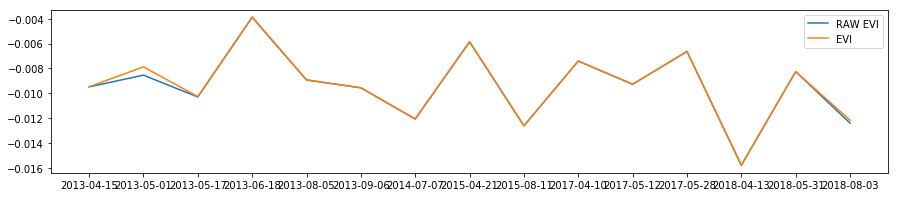

In [38]:
# Show EVI over time

plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['RAW EVI'])
plt.plot(clean_df.index, clean_df['EVI'])
plt.legend()
plt.show()

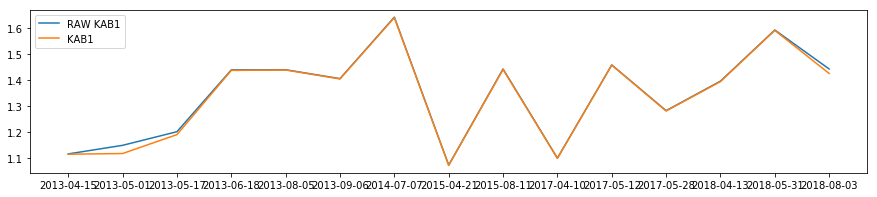

In [39]:
# Show KAB1 over time

plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['RAW KAB1'])
plt.plot(clean_df.index, clean_df['KAB1'])
plt.legend()
plt.show()

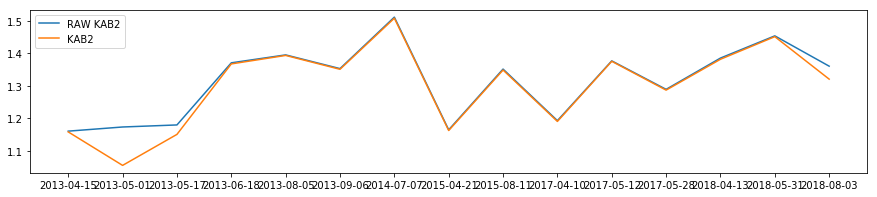

In [40]:
# Show KAB2 over time

plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['RAW KAB2'])
plt.plot(clean_df.index, clean_df['KAB2'])
plt.legend()
plt.show()

### 13. Detection by threshold.

In [41]:
# Clear clouds and calculate EVI
clean_df['RAW EVI'] = 0
clean_df['EVI'] = 0
clean_df['RAW KAB1'] = 0
clean_df['KAB1'] = 0
clean_df['RAW KAB2'] = 0
clean_df['KAB2'] = 0

for idx in clean_df.index:
    cloud_object = PixelQA(clean_df.loc[idx][5])
    evi_image = calculate_indicator(clean_df.loc[idx].values, 'evi')
    clear_clouds = cloud_object.clear_pixels(evi_image)
    clean_df.loc[idx, 'RAW EVI'] = np.nanmean(evi_image[evi_image > 0])
    clean_df.loc[idx, 'EVI'] = np.nanmean(clear_clouds[clear_clouds > 0])
    
    kab1_image = calculate_indicator(clean_df.loc[idx].values, 'kab1')
    clear_clouds = cloud_object.clear_pixels(kab1_image)
    clean_df.loc[idx, 'RAW KAB1'] = np.nanmean(kab1_image[kab1_image > 0])
    clean_df.loc[idx, 'KAB1'] = np.nanmean(clear_clouds[clear_clouds > 0])
    
    kab2_image = calculate_indicator(clean_df.loc[idx].values, 'kab2')
    clear_clouds = cloud_object.clear_pixels(kab2_image)
    clean_df.loc[idx, 'RAW KAB2'] = np.nanmean(kab2_image[kab2_image > 0])
    clean_df.loc[idx, 'KAB2'] = np.nanmean(clear_clouds[clear_clouds > 0])

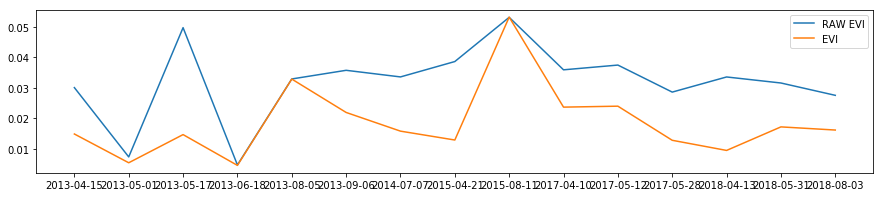

In [42]:
# Show EVI over time

plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['RAW EVI'])
plt.plot(clean_df.index, clean_df['EVI'])
plt.legend()
plt.show()

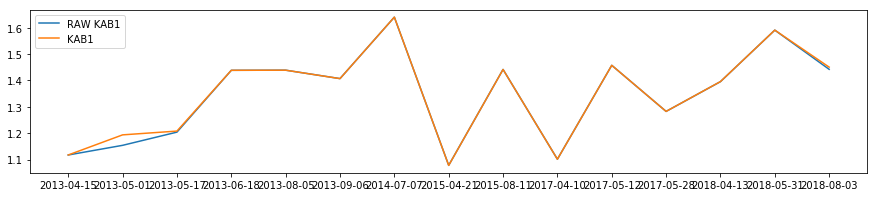

In [43]:
# Show KAB1 over time

plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['RAW KAB1'])
plt.plot(clean_df.index, clean_df['KAB1'])
plt.legend()
plt.show()

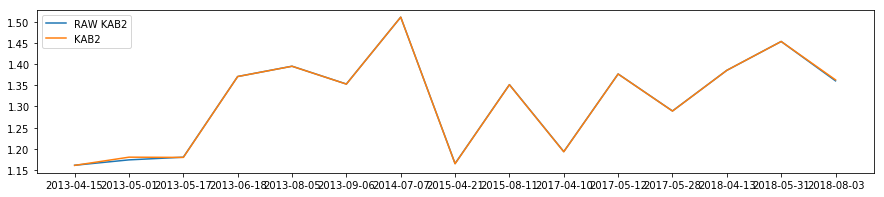

In [44]:
# Show KAB2 over time

plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['RAW KAB2'])
plt.plot(clean_df.index, clean_df['KAB2'])
plt.legend()
plt.show()

### 14. Differentiation

In [48]:
diff_evi_band = algae = calculate_indicator(
    clean_df[clean_df.index == '2013-05-01'].values[0], 'evi')
diff_qa = PixelQA(clean_df.loc['2013-05-01'][5])
diff_evi_band = diff_qa.clear_pixels(diff_evi_band)

diff_kab1_band = algae = calculate_indicator(
    clean_df[clean_df.index == '2013-05-01'].values[0], 'kab1')
diff_kab1_band = diff_qa.clear_pixels(diff_kab1_band)

diff_kab2_band = algae = calculate_indicator(
    clean_df[clean_df.index == '2013-05-01'].values[0], 'kab2')
diff_kab2_band = diff_qa.clear_pixels(diff_kab2_band)


# Clear clouds, calculate EVI and differentiate bands
clean_df['RAW EVI'] = 0
clean_df['EVI'] = 0
clean_df['DIFF EVI'] = 0

clean_df['RAW KAB1'] = 0
clean_df['KAB1'] = 0
clean_df['DIFF KAB1'] = 0

clean_df['RAW KAB2'] = 0
clean_df['KAB2'] = 0
clean_df['DIFF KAB2'] = 0

for idx in clean_df.index:
    cloud_object = PixelQA(clean_df.loc[idx][5])
    evi_image = calculate_indicator(clean_df.loc[idx].values, 'evi')
    clear_clouds = cloud_object.clear_pixels(evi_image)
    difference_evi = diff_evi_band - clear_clouds
    clean_df.loc[idx, 'RAW EVI'] = np.nanmean(evi_image[evi_image > 0])
    clean_df.loc[idx, 'EVI'] = np.nanmean(clear_clouds[clear_clouds > 0])
    clean_df.loc[idx, 'DIFF EVI'] = np.nanmean(difference_evi[difference_evi > 0])
    
    kab1_image = calculate_indicator(clean_df.loc[idx].values, 'kab1')
    clear_clouds = cloud_object.clear_pixels(kab1_image)
    difference_kab1 = diff_kab1_band - clear_clouds
    clean_df.loc[idx, 'RAW KAB1'] = np.nanmean(kab1_image[kab1_image > 0])
    clean_df.loc[idx, 'KAB1'] = np.nanmean(clear_clouds[clear_clouds > 0])
    clean_df.loc[idx, 'DIFF KAB1'] = np.nanmean(difference_kab1[difference_kab1 > 0])
    
    kab2_image = calculate_indicator(clean_df.loc[idx].values, 'kab2')
    clear_clouds = cloud_object.clear_pixels(kab2_image)
    difference_kab2 = diff_kab2_band - clear_clouds
    clean_df.loc[idx, 'RAW KAB2'] = np.nanmean(kab2_image[kab2_image > 0])
    clean_df.loc[idx, 'KAB2'] = np.nanmean(clear_clouds[clear_clouds > 0])
    clean_df.loc[idx, 'DIFF KAB2'] = np.nanmean(difference_kab2[difference_kab2 > 0])
    

/Users/szymon/anaconda3/envs/l8p/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/Users/szymon/anaconda3/envs/l8p/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/Users/szymon/anaconda3/envs/l8p/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


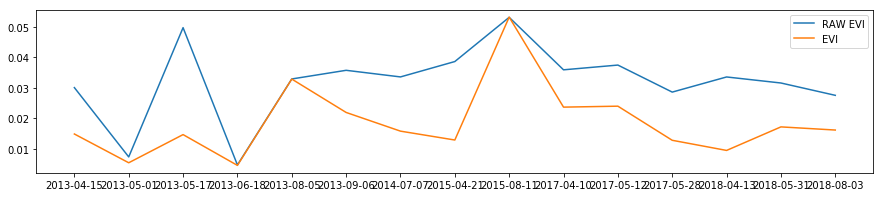

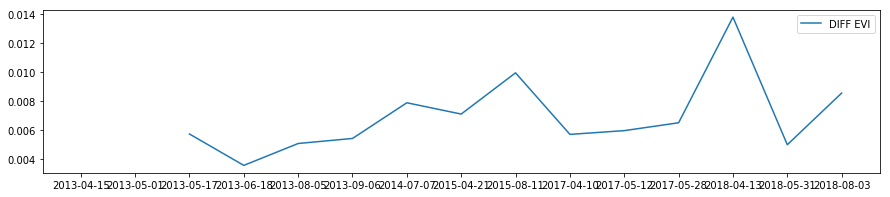

In [50]:
# Show EVI over time

plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['RAW EVI'])
plt.plot(clean_df.index, clean_df['EVI'])
plt.legend()
plt.show()
plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['DIFF EVI'])
plt.legend()
plt.show()

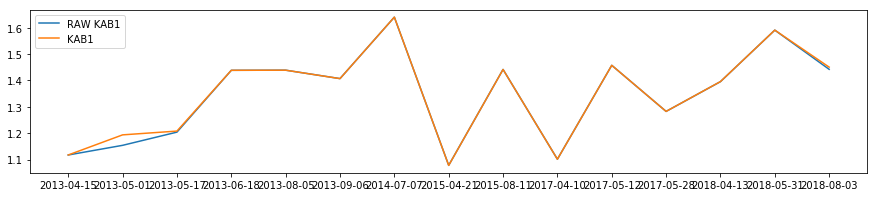

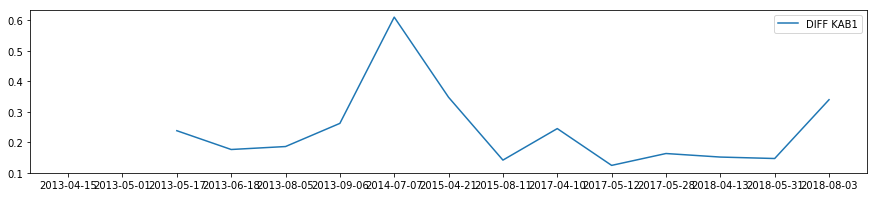

In [51]:
# Show Kab1 over time

plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['RAW KAB1'])
plt.plot(clean_df.index, clean_df['KAB1'])
plt.legend()
plt.show()
plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['DIFF KAB1'])
plt.legend()
plt.show()

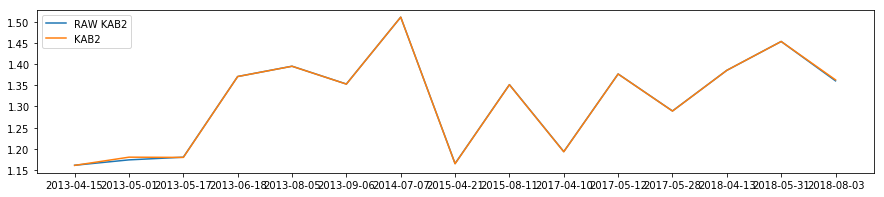

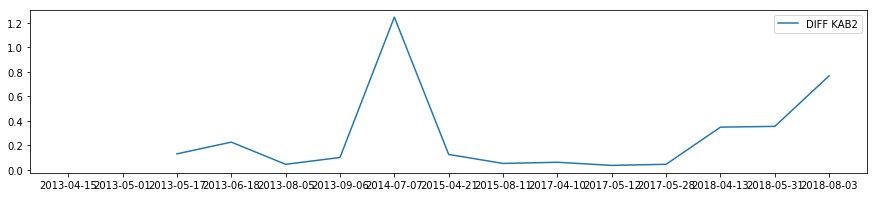

In [52]:
# Show Kab2 over time

plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['RAW KAB2'])
plt.plot(clean_df.index, clean_df['KAB2'])
plt.legend()
plt.show()
plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['DIFF KAB2'])
plt.legend()
plt.show()

In [53]:
clean_df

,DIR,0,1,2,3,4,5,RAW EVI,EVI,RAW KAB1,KAB1,RAW KAB2,KAB2,DIFF EVI,DIFF KAB1,DIFF KAB2
DATE,,,,,,,,,,,,,,,,
2013-04-15,data/rasters/LC081900222013041501T1-SC20180614...,data/clipped/LC_band1_2013-04-15.tif,data/clipped/LC_band2_2013-04-15.tif,data/clipped/LC_band3_2013-04-15.tif,data/clipped/LC_band4_2013-04-15.tif,data/clipped/LC_band5_2013-04-15.tif,data/clipped/LC_band_2013-04-15_pixel_qa.tif,0.030090,0.014819,1.117173,1.117219,1.160923,1.160637,0.005500,0.211877,0.065042
2013-05-01,data/rasters/LC081900222013050101T1-SC20180614...,data/clipped/LC_band1_2013-05-01.tif,data/clipped/LC_band2_2013-05-01.tif,data/clipped/LC_band3_2013-05-01.tif,data/clipped/LC_band4_2013-05-01.tif,data/clipped/LC_band5_2013-05-01.tif,data/clipped/LC_band_2013-05-01_pixel_qa.tif,0.007272,0.005348,1.153817,1.193525,1.173660,1.180043,NaN,NaN,NaN
2013-05-17,data/rasters/LC081900222013051701T1-SC20180614...,data/clipped/LC_band1_2013-05-17.tif,data/clipped/LC_band2_2013-05-17.tif,data/clipped/LC_band3_2013-05-17.tif,data/clipped/LC_band4_2013-05-17.tif,data/clipped/LC_band5_2013-05-17.tif,data/clipped/LC_band_2013-05-17_pixel_qa.tif,0.049824,0.014620,1.203920,1.207909,1.179952,1.179453,0.005736,0.237610,0.131728
2013-06-18,data/rasters/LC081900222013061801T1-SC20180614...,data/clipped/LC_band1_2013-06-18.tif,data/clipped/LC_band2_2013-06-18.tif,data/clipped/LC_band3_2013-06-18.tif,data/clipped/LC_band4_2013-06-18.tif,data/clipped/LC_band5_2013-06-18.tif,data/clipped/LC_band_2013-06-18_pixel_qa.tif,0.004629,0.004485,1.438497,1.438540,1.370516,1.370405,0.003570,0.176005,0.227311
2013-08-05,data/rasters/LC081900222013080501T1-SC20180614...,data/clipped/LC_band1_2013-08-05.tif,data/clipped/LC_band2_2013-08-05.tif,data/clipped/LC_band3_2013-08-05.tif,data/clipped/LC_band4_2013-08-05.tif,data/clipped/LC_band5_2013-08-05.tif,data/clipped/LC_band_2013-08-05_pixel_qa.tif,0.032934,0.032899,1.439041,1.438975,1.394824,1.394706,0.005080,0.185711,0.046612
2013-09-06,data/rasters/LC081900222013090601T1-SC20180614...,data/clipped/LC_band1_2013-09-06.tif,data/clipped/LC_band2_2013-09-06.tif,data/clipped/LC_band3_2013-09-06.tif,data/clipped/LC_band4_2013-09-06.tif,data/clipped/LC_band5_2013-09-06.tif,data/clipped/LC_band_2013-09-06_pixel_qa.tif,0.035784,0.021911,1.407058,1.406969,1.352775,1.352557,0.005429,0.261627,0.102277
2014-07-07,data/rasters/LC081900222014070701T1-SC20180614...,data/clipped/LC_band1_2014-07-07.tif,data/clipped/LC_band2_2014-07-07.tif,data/clipped/LC_band3_2014-07-07.tif,data/clipped/LC_band4_2014-07-07.tif,data/clipped/LC_band5_2014-07-07.tif,data/clipped/LC_band_2014-07-07_pixel_qa.tif,0.033606,0.015758,1.640239,1.640340,1.510698,1.510726,0.007890,0.609870,1.245110
2015-04-21,data/rasters/LC081900222015042101T1-SC20180614...,data/clipped/LC_band1_2015-04-21.tif,data/clipped/LC_band2_2015-04-21.tif,data/clipped/LC_band3_2015-04-21.tif,data/clipped/LC_band4_2015-04-21.tif,data/clipped/LC_band5_2015-04-21.tif,data/clipped/LC_band_2015-04-21_pixel_qa.tif,0.038668,0.012837,1.077908,1.077699,1.164986,1.164586,0.007111,0.347173,0.127069
2015-08-11,data/rasters/LC081900222015081101T1-SC20180614...,data/clipped/LC_band1_2015-08-11.tif,data/clipped/LC_band2_2015-08-11.tif,data/clipped/LC_band3_2015-08-11.tif,data/clipped/LC_band4_2015-08-11.tif,data/clipped/LC_band5_2015-08-11.tif,data/clipped/LC_band_2015-08-11_pixel_qa.tif,0.053219,0.053288,1.441935,1.441745,1.351327,1.351056,0.009955,0.141250,0.053818


In [43]:
def check_bloom(raw_evi, evi, diff_evi, raw_thresh, thresh, diff_thresh):
    if (raw_evi > raw_thresh) and (evi > thresh) and (diff_evi > diff_thresh):
        return True
    else:
        return False
t1 = 0.04
t2 = 0.04
t3 = 0.008
clean_df['BLOOM'] = clean_df.apply(lambda x: check_bloom(x['RAW EVI'], x['EVI'], x['DIFF EVI'],
                                                        t1, t2, t3), axis=1)

In [44]:
clean_df

,DIR,0,1,2,3,RAW EVI,EVI,DIFF EVI,BLOOM
DATE,,,,,,,,,
2013-04-15,data/rasters/LC081900222013041501T1-SC20180614...,data/clipped/LC_band2_2013-04-15.tif,data/clipped/LC_band4_2013-04-15.tif,data/clipped/LC_band5_2013-04-15.tif,data/clipped/LC_band_2013-04-15_pixel_qa.tif,0.030090,0.014819,0.005500,False
2013-05-01,data/rasters/LC081900222013050101T1-SC20180614...,data/clipped/LC_band2_2013-05-01.tif,data/clipped/LC_band4_2013-05-01.tif,data/clipped/LC_band5_2013-05-01.tif,data/clipped/LC_band_2013-05-01_pixel_qa.tif,0.007272,0.005348,NaN,False
2013-05-17,data/rasters/LC081900222013051701T1-SC20180614...,data/clipped/LC_band2_2013-05-17.tif,data/clipped/LC_band4_2013-05-17.tif,data/clipped/LC_band5_2013-05-17.tif,data/clipped/LC_band_2013-05-17_pixel_qa.tif,0.049824,0.014620,0.005736,False
2013-06-18,data/rasters/LC081900222013061801T1-SC20180614...,data/clipped/LC_band2_2013-06-18.tif,data/clipped/LC_band4_2013-06-18.tif,data/clipped/LC_band5_2013-06-18.tif,data/clipped/LC_band_2013-06-18_pixel_qa.tif,0.004629,0.004485,0.003570,False
2013-08-05,data/rasters/LC081900222013080501T1-SC20180614...,data/clipped/LC_band2_2013-08-05.tif,data/clipped/LC_band4_2013-08-05.tif,data/clipped/LC_band5_2013-08-05.tif,data/clipped/LC_band_2013-08-05_pixel_qa.tif,0.032934,0.032899,0.005080,False
2013-09-06,data/rasters/LC081900222013090601T1-SC20180614...,data/clipped/LC_band2_2013-09-06.tif,data/clipped/LC_band4_2013-09-06.tif,data/clipped/LC_band5_2013-09-06.tif,data/clipped/LC_band_2013-09-06_pixel_qa.tif,0.035784,0.021911,0.005429,False
2014-07-07,data/rasters/LC081900222014070701T1-SC20180614...,data/clipped/LC_band2_2014-07-07.tif,data/clipped/LC_band4_2014-07-07.tif,data/clipped/LC_band5_2014-07-07.tif,data/clipped/LC_band_2014-07-07_pixel_qa.tif,0.033606,0.015758,0.007890,False
2015-04-21,data/rasters/LC081900222015042101T1-SC20180614...,data/clipped/LC_band2_2015-04-21.tif,data/clipped/LC_band4_2015-04-21.tif,data/clipped/LC_band5_2015-04-21.tif,data/clipped/LC_band_2015-04-21_pixel_qa.tif,0.038668,0.012837,0.007111,False
2015-08-11,data/rasters/LC081900222015081101T1-SC20180614...,data/clipped/LC_band2_2015-08-11.tif,data/clipped/LC_band4_2015-08-11.tif,data/clipped/LC_band5_2015-08-11.tif,data/clipped/LC_band_2015-08-11_pixel_qa.tif,0.053219,0.053288,0.009955,True


In [45]:
clean_df.index[clean_df['BLOOM'] == True].values

array(['2015-08-11'], dtype=object)

In [46]:
def infested_area(band1, band2, band3, evi_threshold):
    with rio.open(band1) as rast:
        pix_size_x, pix_size_y = rast.res
    
    evi = calculate_evi([band1, band2, band3])
    evi[evi < evi_threshold] = 0
    
    return np.count_nonzero(evi) * (pix_size_x * pix_size_y)

print(clean_df.apply(lambda x: (infested_area(x[0], x[1], x[2], t1) if x['BLOOM'] else -1), axis=1))

DATE
2013-04-15         -1.0
2013-05-01         -1.0
2013-05-17         -1.0
2013-06-18         -1.0
2013-08-05         -1.0
2013-09-06         -1.0
2014-07-07         -1.0
2015-04-21         -1.0
2015-08-11    1899900.0
2017-04-10         -1.0
2017-05-12         -1.0
2017-05-28         -1.0
2018-04-13         -1.0
2018-05-31         -1.0
2018-08-03         -1.0
dtype: float64


### 15. Put it all together!

--- Object geometry, properties, crs and schema updated ---
File: data/clipped/LC_band2_2013-04-15.tif saved successfully
File: data/clipped/LC_band4_2013-04-15.tif saved successfully
File: data/clipped/LC_band5_2013-04-15.tif saved successfully
QA file: data/clipped/LC_band_2013-04-15_pixel_qa.tif saved successfully
File: data/clipped/LC_band2_2013-05-01.tif saved successfully
File: data/clipped/LC_band4_2013-05-01.tif saved successfully
File: data/clipped/LC_band5_2013-05-01.tif saved successfully
QA file: data/clipped/LC_band_2013-05-01_pixel_qa.tif saved successfully
File: data/clipped/LC_band2_2013-05-17.tif saved successfully
File: data/clipped/LC_band4_2013-05-17.tif saved successfully
File: data/clipped/LC_band5_2013-05-17.tif saved successfully
QA file: data/clipped/LC_band_2013-05-17_pixel_qa.tif saved successfully
File: data/clipped/LC_band2_2013-06-18.tif saved successfully
File: data/clipped/LC_band4_2013-06-18.tif saved successfully
File: data/clipped/LC_band5_2013-06-18.

/Users/szymon/anaconda3/envs/l8p/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


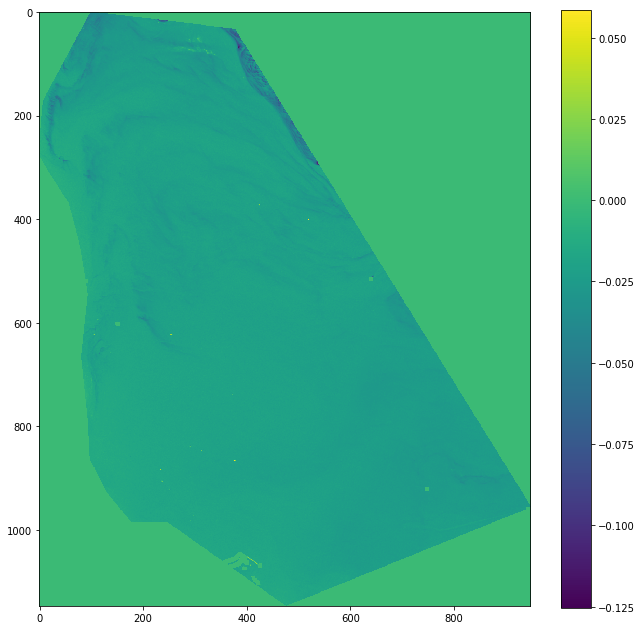

Date of acquisition: 2014-07-07. 
Mean EVI: 0.01575820992997062. 
Infested Area: 236700.0 square meters.


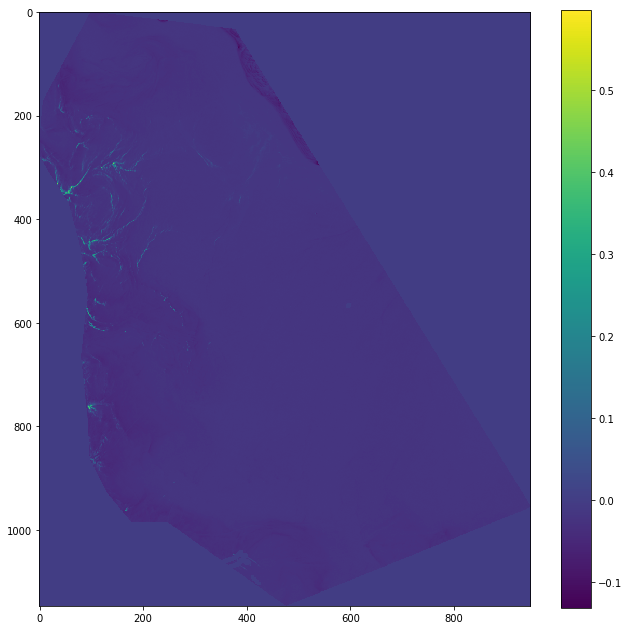

Date of acquisition: 2015-08-11. 
Mean EVI: 0.05328756349699306. 
Infested Area: 3737700.0 square meters.


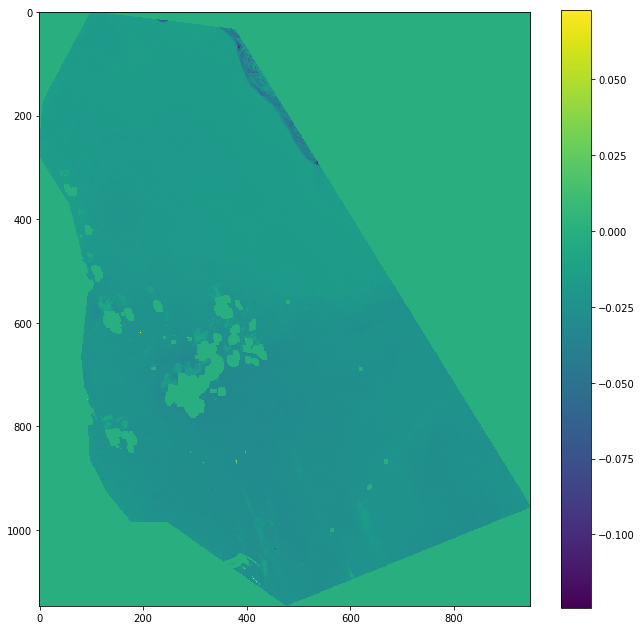

Date of acquisition: 2018-08-03. 
Mean EVI: 0.016121179185092614. 
Infested Area: 2294100.0 square meters.


In [49]:
# Read and prepare vector data
vector_file = 'data/vector/zatoka_v2.shp'
vector_data = VectorData(vector_file)
vector_data.get_vector_data('geometry', True)

# Get projection from raster file
df = algal_blooms.landsat_dataframe
landsat_images = read_landsat_images(df['DIR'][0])
epsg = get_epsg_from_raster(landsat_images[1])

# Reproject vector geometry
vn = vector_data.reproject_geometry(epsg, False)

# Prepare area of interest
my_bands = (2, 4, 5)  # bands for EVI calculation
my_folder_name = 'data/clipped/'
prepared_files = clip_all(df, vn, my_bands, True, my_folder_name)

# Prepare dataframe and calculate EVI
clean_df = rasters_to_dataframe(prepared_files, df)

# Prepare reference band

bands = [clean_df[clean_df.index == '2013-05-01'][0][0],
        clean_df[clean_df.index == '2013-05-01'][1][0],
        clean_df[clean_df.index == '2013-05-01'][2][0]]

diff_band = calculate_evi(bands)
diff_qa = PixelQA(clean_df.loc['2013-05-01', 3])
diff_band = diff_qa.clear_pixels(diff_band)


# Clear clouds, calculate EVI and differentiate bands

clean_df['RAW EVI'] = 0
clean_df['EVI'] = 0
clean_df['DIFF EVI'] = 0
for idx in clean_df.index:
    cloud_object = PixelQA(clean_df.loc[idx][3])
    evi_image = calculate_evi([clean_df.loc[idx][0], clean_df.loc[idx][1], clean_df.loc[idx][2]])
    clear_clouds = cloud_object.clear_pixels(evi_image)
    difference = diff_band - clear_clouds
    clean_df.loc[idx, 'RAW EVI'] = np.nanmean(evi_image[evi_image > 0])
    clean_df.loc[idx, 'EVI'] = np.nanmean(clear_clouds[clear_clouds > 0])
    clean_df.loc[idx, 'DIFF EVI'] = np.nanmean(difference[difference > 0])

# Detect algal blooms

t1 = 0.01
t2 = 0.01
t3 = 0.0075
clean_df['BLOOM'] = clean_df.apply(lambda x: check_bloom(x['RAW EVI'], x['EVI'], x['DIFF EVI'],
                                                        t1, t2, t3), axis=1)

# Calculate infested area

clean_df['INFESTED AREA'] = clean_df.apply(lambda x: (infested_area(x[0], x[1], x[2], t1) if x['BLOOM'] else -1),
                                           axis=1)

# Return dates with algal blooms and show images of these

hot_points = clean_df.index[clean_df['BLOOM'] == True].values
for point in hot_points:
    
    # Prepare evi image without clouds
    cloud_object = PixelQA(clean_df.loc[point][3])
    evi_image = calculate_evi([clean_df.loc[point][0], clean_df.loc[point][1], clean_df.loc[point][2]])
    clear_clouds = cloud_object.clear_pixels(evi_image)
    
    # Show data
    show_band(clear_clouds, color_map='viridis', remove_negative=False)
    
    # Print basic information
    info = 'Date of acquisition: {}. \nMean EVI: {}. \nInfested Area: {} square meters.'.format(
        point, clean_df.loc[point]['EVI'], clean_df.loc[point]['INFESTED AREA'])
    print(info)

# And prepare data for more detailed analysis...